In [2]:
# Packages

# Math
import numpy as np

# Data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


import csv
from pathlib import Path
import sys
import os
import glob
from wordcloud import WordCloud

# Models

path_root = Path('/home/chay/CDD/my_functions.py').parents[0]
sys.path.append(str(path_root))
print(sys.path)

from my_functions import *

PATH = '/home/chay/CDD/'

['/home/chay/CDD', '/home/chay/anaconda3/lib/python311.zip', '/home/chay/anaconda3/lib/python3.11', '/home/chay/anaconda3/lib/python3.11/lib-dynload', '', '/home/chay/anaconda3/lib/python3.11/site-packages', '/home/chay/CDD']


[nltk_data] Downloading package punkt to /home/chay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/chay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Para hacer Fuzzy-Kmeans
from fcmeans import FCM

# 1) Identificar archivos 'OR.csv'

In [2]:
# Directorio donde se encuentran las conferencias.
dir_data = '/home/chay/CDD/conferencias_matutinas_amlo-master/'

# Tenemos interés en 
years = ['2019/', '2020/', '2021/', '2022/', '2023/']

# Se almacenan los paths de cada archivo
file_paths = []
extension = 'OR.csv'

# Se itera sobre los años de interés
for year in years:
    # Se concatenan los 
    year_folder = os.path.join(dir_data, year)
    
    # Verificamos si el archivo existe
    if os.path.exists(year_folder):
        # Recursive search for files ending with 'Ob.csv' in the year folder
        file_paths.extend(glob.glob(os.path.join(dir_data, '**', f'*{extension}'), recursive=True))

# Creamos el dataFrame
mananeras = pd.DataFrame({'path': file_paths})

# 2) Se extrae la segunda columna y la fecha

In [3]:
# Función para extraer la columna 2 en raw y la date
def extract_col(f):

    with open(f, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header row
        # Extraemos día mes y año
        first = next(reader)
        date  = first[6]+'-'+first[5]+'-'+first[4]
        # Extraemos la segunda columna
        first_row = [first[1]]
        second_column = [row[1] for row in reader]
        column = first_row + second_column 
        # Unimos todas las frases en una sola
        s = ' ' #Las unimos por un espacio
        s = s.join(column)
    
    return s, date

In [4]:
# Agregamos la columna 'raw' que contiene todas las palabras 
# del presidente en la mañanera de un día en paçrticular
# Agregamos además la columna date para saber qué día lo dijo
mananeras['raw'], mananeras['date'] = zip(*mananeras['path'].apply(extract_col))

# Convertimos la columna date a formato 'YYYY-MM-DD'
mananeras['date'] = pd.to_datetime(mananeras['date'], format='%Y-%m-%d')

## En este punto no importa si entraron datos antes de 2019 porque podemos filtrar
## la tabla después por la fecha.

# Seleccionamos los años que correspondan al intervalo de tiempo deseado.
# 2019-01-01 -> 2023-12-31
mananeras_4a = mananeras[(mananeras['date'] <= '2023-12-31') & (mananeras['date'] >= '2019-01-01')]

# Tomamos la fecha como índice
mananeras_4a.set_index('date', inplace=True)

mananeras_4a.head()

,path,raw
date,,
2023-07-25,/home/chay/CDD/conferencias_matutinas_amlo-mas...,"Muy buenos días. Ánimo. Bueno, vamos a inform..."
2023-07-19,/home/chay/CDD/conferencias_matutinas_amlo-mas...,"Buenos días. Ánimo. Hoy es miércoles, es un d..."
2023-07-13,/home/chay/CDD/conferencias_matutinas_amlo-mas...,"Buenos días. Ánimo, ánimo. Bueno, el día de h..."
2023-07-26,/home/chay/CDD/conferencias_matutinas_amlo-mas...,"Buenos días. Ánimo. Tarde, pero seguro. Vamos..."
2023-07-04,/home/chay/CDD/conferencias_matutinas_amlo-mas...,"Buenos días. Ánimo, Bueno, pues hoy es martes..."


# 3) Agrupar los datos por semana en un nuevo data frame


In [5]:
# Ahora sólo vamos a conservar los datos de la columna raw
mananeras_weekly = mananeras_4a.resample('W-SUN')['raw'].apply(' '.join)
mananeras_weekly

date
2019-01-06    : Buenos días. Primero, reiterar nuestra manif...
2019-01-13    : Buenos días. Estamos terminando el periodo c...
2019-01-20    : Buenos días. El día de hoy vamos a informar ...
2019-01-27    : Buenos días. Vamos a informar sobre el plan ...
2019-02-03    : Buenos días. Vamos a informar y al mismo tie...
                                    ...                        
2023-12-03     Buenos días-tarde-noches. Ánimo. Bueno, pues ...
2023-12-10     Buenos días. ¿Cómo están? Ánimo, ánimo. Vamos...
2023-12-17     Buenos días. Ánimo, ánimo. Ya empezó el frío ...
2023-12-24     Buenos, días. Ánimo. Vamos a informar sobre ‘...
2023-12-31     Buenos días. Ánimo, ya va a pasar la gripa. ¿...
Freq: W-SUN, Name: raw, Length: 261, dtype: object

# 4) Preprocesar el texto

In [6]:
# Definimos el preprocesador con la clase apropiada
preprocesador = preprocesaTexto(idioma='es', _tokeniza=False, _muestraCambios=False, _quitarAcentos=False, 
                                _remueveStop=True, _stemming=False)
mananeras_weekly_preprocessed = mananeras_weekly.apply(preprocesador.preprocesa)
mananeras_weekly_preprocessed

date
2019-01-06    buenos días primero reiterar manifestación des...
2019-01-13    buenos días terminando periodo conocido guadal...
2019-01-20    buenos días día hoy vamos informar plan combat...
2019-01-27    buenos días vamos informar plan general combat...
2019-02-03    buenos días vamos informar mismo tiempo contes...
                                    ...                        
2023-12-03    buenos díastardenoches ánimo bueno pues vamos ...
2023-12-10    buenos días cómo ánimo ánimo vamos lunes infor...
2023-12-17    buenos días ánimo ánimo empezó frío lluvia bue...
2023-12-24    buenos días ánimo vamos informar quién quién p...
2023-12-31    buenos días ánimo va pasar gripa cómo va gripa...
Freq: W-SUN, Name: raw, Length: 261, dtype: object

In [7]:
# GUARDAR A UN CSV Y REINICIAR KERNEL PARA LIBERAR MEMORIA
mananeras_weekly_preprocessed.to_csv('/home/chay/CDD/Tarea3_CDD/mananeras_weekly_preprocessed.csv', index=True)

# 5) Elegir los tópicos más destacables

In [4]:
# Partimos desde este punto con los datos preprocesados por semana
mananeras_weekly_preprocessed = pd.read_csv('/home/chay/CDD/Tarea3_CDD/mananeras_weekly_preprocessed.csv',index_col='date',header='infer')

In [5]:
mananeras_weekly_preprocessed['raw'][108] = ' '
mananeras_weekly_preprocessed['raw'][109] = ' '

## a) Primero verificamos las palabras mas comunes entre el texto

In [6]:
# Unimos todas las mananeras en un solo texto
texto_mananeras = ' '.join(mananeras_weekly_preprocessed['raw'])

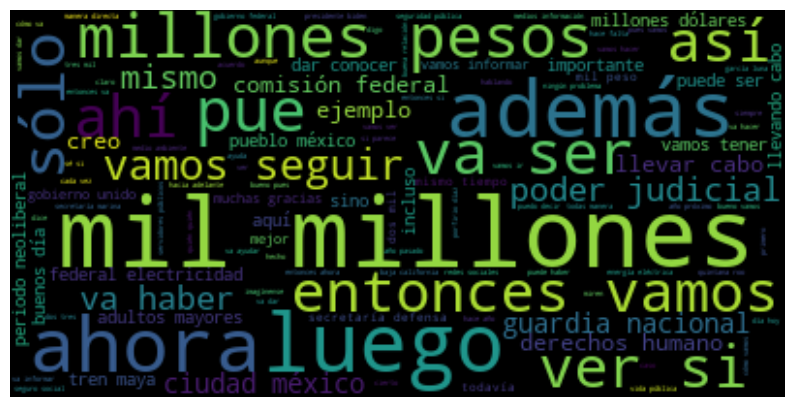

In [6]:
wordcloud = WordCloud(max_font_size=50).generate(texto_mananeras)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
# Se remueven adverbios y adjetivos.
adjec_adverbs = [
    # Adverbios de lugar
    "aquí", "allí", "allá", "acá", "cerca", "lejos", "dentro", "fuera", "encima", "debajo",
    "enfrente", "atrás", "alrededor",
    # Adverbios de tiempo
    "ahora", "nunca", "hoy", "ayer", "mañana", "siempre", "pronto", "tarde", "temprano",
    "ya", "después", "entonces", "todavía", "anoche", "antes",
    # Adverbios de modo
    "bien", "mal", "así", "despacio", "rápido", "mejor", "peor", "fácilmente", "difícilmente", 
    "cuidadosamente", "tranquilamente", "alegremente",
    # Adverbios de cantidad
    "mucho", "poco", "bastante", "demasiado", "más", "menos", "algo", "nada", "todo", "suficiente",
    # Adverbios de duda
    "quizá", "tal vez", "acaso", "probablemente", "posiblemente",
    # Adverbios de negación
    "no", "nunca", "jamás",
    # Adverbios de afirmación
    "sí", "también", "ciertamente", "seguramente",
    # Adverbios interrogativos
    "cuándo", "cómo", "dónde", "cuánto", "por qué",
    # Adverbios exclamativos
    "qué", "cuánto", "cómo",
    # Adjetivos demostrativos
    "este", "ese", "aquel", "esta", "esa", "aquella", "estos", "esos", "aquellos", "estas", "esas", "aquellas",
    # Adjetivos posesivos
    "mi", "tu", "su", "nuestro", "vuestro", "mis", "tus", "sus", "nuestros", "vuestros",
    # Adjetivos numerales
    "uno", "dos", "tres", "primer", "segundo", "tercer", "doble", "triple",
    # Adjetivos indefinidos
    "algún", "ningún", "poco", "mucho", "demasiado", "bastante", "varios", "otros", "cualquier", "todo", "mismo",
    # Adjetivos exclamativos
    "qué", "cuánto", "cuán",
    # Adjetivos relativos
    "cuyo", "cuya", "cuyos", "cuyas",
    # Adjetivos calificativos
    "grande", "pequeño", "alto", "bajo", "bonito", "feo", "rápido", "lento", "nuevo", "viejo"
]

# Funcion para remover palabras especificas de la serie de pandas
def remove_specific_words(text,words_to_remove):
    
    words = text.split()

    filtered_words = [word for word in words if word not in words_to_remove]
    
    # Join the filtered words back into a single text
    filtered_text = ' '.join(filtered_words)

    return filtered_text

# Aplicamos la función para eliminar las palabras en cada registro 
mananeras_filtradas = mananeras_weekly_preprocessed['raw'].apply(lambda txt : remove_specific_words(txt,adjec_adverbs))

mananeras_filtradas

date
2019-01-06    buenos días primero reiterar manifestación des...
2019-01-13    buenos días terminando periodo conocido guadal...
2019-01-20    buenos días día vamos informar plan combatir r...
2019-01-27    buenos días vamos informar plan general combat...
2019-02-03    buenos días vamos informar tiempo contestar pr...
                                    ...                        
2023-12-03    buenos díastardenoches ánimo bueno pues vamos ...
2023-12-10    buenos días ánimo ánimo vamos lunes informar q...
2023-12-17    buenos días ánimo ánimo empezó frío lluvia bue...
2023-12-24    buenos días ánimo vamos informar quién quién p...
2023-12-31    buenos días ánimo va pasar gripa va gripa pasa...
Name: raw, Length: 261, dtype: object

In [12]:
otras = [
    'abajo', 'acerca', 'además', 'afortunadamente', 'ah', 'ahora', 'ahí', 'allá', 'aqui', 'aquí', 
    'así', 'atendiendo', 'aunque', 'ayer', 'buen', 'bueno', 'buenos', 'cabo', 'cada', 'casi', 'caso', 
    'ciento', 'cierto', 'cinco', 'claro', 'conocer', 'corresponde', 'cosa', 'cosas', 'creo', 'cualquier',
    'cuatro', 'cuánto', 'cómo', 'da', 'dar', 'debe', 'decir', 'decía', 'dejar', 'después', 'dice', 'dicen', 'dicho',
    'digo', 'dije', 'dijo', 'dio', 'dos', 'día', 'dónde', 'ejemplo', 'empresarios', 'entonces', 'existe', 'falta', 'fin',
    'forma', 'gracias', 'gran', 'grandes', 'haber', 'hablando', 'hablar', 'hablo', 'hace', 'hacen', 'hacer', 'hacia',
    'haciendo', 'hicieron', 'hizo', 'hoy', 'iba', 'iban', 'imagínense', 'incluso', 'ir', 'llama', 'llegar', 'llevando', 
    'llevar', 'luego', 'lunes', 'manera', 'mañana', 'medio', 'mil', 'millones', 'miren', 'mismo', 'momento', 'mucha', 
    'muchas', 'muchísimo', 'nadie', 'ninguna', 'ningún', 'nivel', 'nunca', 'ojalá', 'parece', 'parte', 'partir', 
    'pasa', 'pendiente', 'pensando', 'podemos', 'poner', 'primer', 'primera', 'primero', 'próximo', 'pue', 'pueda', 
    'puede', 'puede ser', 'pueden', 'puedo', 'pues', 'queremos', 'quien', 'quiere', 'quieren', 'quiero', 'quién', 
    'repito', 'sabe', 'saben', 'seguir', 'segundo', 'seis', 'semana', 'ser', 'si', 'siempre', 'sino', 'sé', 'sólo',
    'tan', 'tema', 'temas', 'tener', 'toda', 'todas', 'todavía', 'tomar', 'tres', 'ustedes', 'va', 'vamos', 'van',
    'veces', 'vemos', 'ver', 'vez', 'viendo', 'viene', 'voy', 'zona','bien','tiempo','importante','mejor','menos',
    'nuevo','arriba','mal','reunión','elementos','mayor','buscar','favor','nueva','entregar','pasado','garantizar',
    'tiempos','resolver','grupo','especial','terminar','ayudando','problemas','principal','pregunta','preguntas',
    'actuar','igual','sido','llegó','vaya','salir','siquiera','lleva','significa','ocho','permitir','pedir','dando',
    'posibilidad','sigue','mes','hacemos','meses','llega','puedan','mantener','modo','buscando','pronto','cuántos',
    'cuidar','posible','cuál','bastante','querían','único','lugar','saber','quedar','san','importa','alrededor',
    'tampoco','misma','gusto','entrega','pasó','pasar','palabra','kilómetros','atrás','usted','tipo','cerca','podría',
    'diciendo','siendo','final','pendientes','deben','esperar','necesitamos','interesante', 'hacían','maneras','lado',
    'hablaba','cumplir','número','quedó','difícil','llevamos','queda','llegamos','continuar','vienen','hacerlo','razón',
    'daño','fuerte','dan','quiénes','podamos','orden','sucedió','habla','ven','requiere','hicimos','participar','darle',
    'cuándo','materia','decían','partes','permite','mitad','santa','llamada','punto','buenas','dieron','fíjense','roo',
    'empezamos','sabemos','decirles','tarde','hablamos','mismos','aun','debemos','espero','distinto','acá','llamado',
    'podía','últimos','modelo','utilizar','vayan','llevó','respuesta','precisamente','lamentable','función','tratar',
    'diciembre','íbamos','condiciones','haga','evitar','último','dé','solo','sucede','completamente',
    'uso','seguramente','hacía','equipo','pesar','básicamente','recibir','importantes',
    'grande','iniciar','fundamental','diría','dado','cuanto','demás','pasando','promedio',
    'manejo','sabía','directa','gusta','sacar','pensar','domingo','noche','mínimo','llevan',
    'siete','mejores','sucediendo','empezar','visto','dejaron','cambiar','horas','martes','lograr',
    'acaba','viernes','sale','decidir','vista','principio','supuestamente','alguien','duda','carta',
    'ánimo','hagan','idea','terminó','quería','quedamos','pienso','ido','considero','nuevos','cero',
    'explicar','doble','necesita','suficiente','afecta','don','actitud','material','acuerdan',
    'sepa','siga','miles','quede','llegando','quedaron','algún','nombre','siguen','termina','acabar',
    'revisar','recibiendo','aclarar','llegan','media','hablé','cuidado','popular','vámonos','habló','paso','vamos','si','va']
# Aplicamos la función para eliminar las palabras en cada registro 
mananeras_filtradas = mananeras_weekly_preprocessed['raw'].apply(lambda txt : remove_specific_words(txt,otras))

In [13]:
from collections import Counter

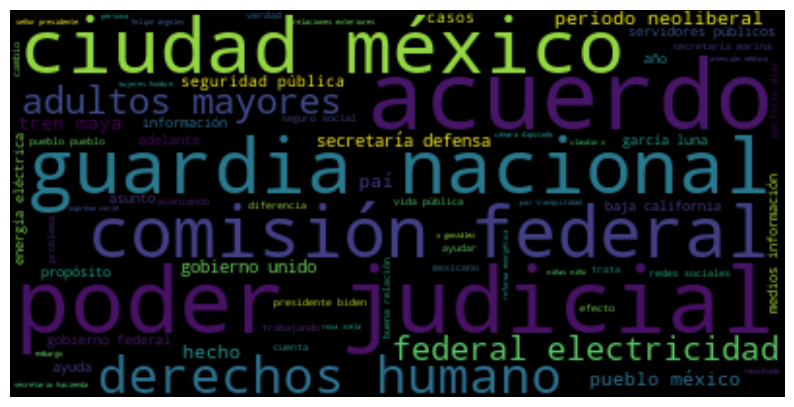

In [14]:
# Unimos todas las mananeras en un solo texto
texto_mananeras = ' '.join(mananeras_filtradas)
wordcloud = WordCloud(max_font_size=50).generate(texto_mananeras)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
#Separamos las palabras
words = texto_mananeras.split()

# Hacemos la cuenta de las palabras más repetidas
word_counts = Counter(words)

# Definimos un vocabulario con las primeras 500 palabras más repetidas "clasificables"
most_repeated = word_counts.most_common(500)
vocab = pd.DataFrame(most_repeated,columns=['word','freq'])

In [16]:
# Este es el vocabulario filtrado que utilizaremos para el fuzzy k-means
vocab

,word,freq
0,méxico,82825
1,gobierno,68930
2,pueblo,68755
3,gente,64555
4,país,46615
...,...,...
495,exteriores,3005
496,inseguridad,3000
497,combustibles,2995
498,hugo,2990


# 6) Determinamos las representaciones con word2vec

In [17]:
from gensim.models import KeyedVectors

## a) Word2vec embeddings

In [18]:
# Cargamos los embeddings pre entrenados con word2vec
word2vec = KeyedVectors.load_word2vec_format(PATH+"SBW-vectors-300-min5-cbow.bin",binary=True)

In [19]:
# Calculamos los embeddings
embeddings_word2vec = []
not_found = []
for word in vocab['word']:
    try:
        embbeding = word2vec[word]
        embeddings_word2vec.append(embbeding)
    except KeyError:
        not_found.append(word)

print('Forma del vocabulario: ',len(embeddings_word2vec))
print('\n Vocabulario no encontrado:\n',not_found)

Forma del vocabulario:  494

 Vocabulario no encontrado:
 ['pemex', 'juárez', 'biden', 'yucatán', 'covid', 'zedillo']


In [20]:
# Removemos el vocabulario no encontrado en los embeddings
w2v_vocab = vocab[~vocab['word'].isin(not_found)].copy()
len(w2v_vocab)

494

In [21]:
# Utilizamos los embeddings_word2vec para hacer el Fuzzy K-means
embeddings_word2vec = np.array(embeddings_word2vec)
embeddings_word2vec.shape

(494, 300)

## Fuzzy K-means : ¿Qué valor de clusters es el adecuado?

In [22]:
# Utilizamos Fuzzy K-means con un grado de Fuzziness m=3
fcm_w2v = FCM(n_clusters=7, m=3)
fcm_w2v.fit(embeddings_word2vec)

#y_fkm = np.matrix(fcm_w2v.predict(embeddings_word2vec)).T
topics_w2v = [
    np.argmin(np.linalg.norm(fcm_w2v.centers-embeddings_word2vec[i],axis=1)) for i in range(len(w2v_vocab))
]
w2v_vocab['topic'] = topics_w2v
w2v_vocab

,word,freq,topic
0,méxico,82825,5
1,gobierno,68930,6
2,pueblo,68755,0
3,gente,64555,2
4,país,46615,5
...,...,...,...
495,exteriores,3005,6
496,inseguridad,3000,6
497,combustibles,2995,5
498,hugo,2990,6


In [23]:
# Los centroides están dados por
fcm_w2v.centers.shape

(7, 300)

## Wordclouds con Fuzzy K-means

In [24]:
# Path para guardar las imagenes
save_path = '/home/chay/CDD/Tarea4_CDD/'

# Función para generar los wordclouds basado en la frecuencia con la que aparecen en el
# texto original
def makeImage(df):
    word_freq_dict = dict(zip(df['word'], df['freq']))
    wc = WordCloud(background_color="white",max_font_size=40)
    # generate word cloud
    wc.generate_from_frequencies(word_freq_dict)

    # show
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    #plt.show()
    # Guardamos la figura en el path especifico
    filename = os.path.join(save_path, f'topic_{topic_label}wc.png')
    plt.savefig(filename,bbox_inches='tight')
    plt.close()  # Close the figure to release memory
    print(f"Figure for topic {topic_label} saved as {filename}")


In [25]:
# Iteramos sobre los topicos
for topic_label in range(7):
    # Llamada a la función de impresión de imagenes
    makeImage(w2v_vocab[w2v_vocab['topic'] == topic_label])

Figure for topic 0 saved as /home/chay/CDD/Tarea4_CDD/topic_0wc.png
Figure for topic 1 saved as /home/chay/CDD/Tarea4_CDD/topic_1wc.png
Figure for topic 2 saved as /home/chay/CDD/Tarea4_CDD/topic_2wc.png
Figure for topic 3 saved as /home/chay/CDD/Tarea4_CDD/topic_3wc.png
Figure for topic 4 saved as /home/chay/CDD/Tarea4_CDD/topic_4wc.png
Figure for topic 5 saved as /home/chay/CDD/Tarea4_CDD/topic_5wc.png
Figure for topic 6 saved as /home/chay/CDD/Tarea4_CDD/topic_6wc.png


## b) Promedio de Embeddings por semana

In [79]:
mananeras_filtradas

date
2019-01-06    días reiterar manifestación deseo año año años...
2019-01-13    días terminando periodo conocido guadalupereye...
2019-01-20    días informar plan combatir robo combustible b...
2019-01-27    días informar plan general combate robo combus...
2019-02-03    días informar contestar iniciaremos informe co...
                                    ...                        
2023-12-03    díastardenoches ainiciarla precios doctor davi...
2023-12-10    días informar precios informar avance tren may...
2023-12-17    días empezó frío lluvia informar precios avanc...
2023-12-24    días informar precios buena noticia buena inau...
2023-12-31    días gripa gripa temporada buena noticia vuelv...
Name: raw, Length: 261, dtype: object

In [26]:
# Function requirements:
# Se requiere un modelo pre entrenado model para buscar los embeddings
# Se requiere el Fuzzy K-means ajustado con los datos para hacer la predicción del embedding promedio.
from collections import Counter

# Función  Obtain_words
def obtain_words(doc,vocab):
    """ Descripción:  Es una función para obtener las palabras que se encuentran en cada
        documento y sus respectivas frecuencias tomando en cuenta que estas también están
        en un vocabulario dado. 
        Entradas: - doc :  Texto
                  - vocab: Vocabulario a buscar
        Salida: Diccionario con {palabra: frecuencia} e.g. {"méxico": 5, "país": 7 ----}"""
    
    # Recuperar las palabras del vocabulario que se encuentran en el texto
    list_of_words = doc.split()
    words_in_doc = []
    for i in range(len(list_of_words)):
        if (list_of_words[i] in vocab):
            words_in_doc.append(list_of_words[i])
    
    # Recuperar la frecuencia de las palabras en el documento.
    word_freq_dict = dict(Counter(words_in_doc).items())

    return word_freq_dict


# Función  embedding_mean
def embedding_mean(word_freq_dict,model,window_size):
    """ Descripción: Es una función para obtener el embedding promedio. 
    Dado que word_freq_dict tiene las frecuencias de cada palabra, el embedding promedio
    será una suma ponderada de los embeddings correspondientes a cada palabra.
    Para asegurar la escalabilidad del código, no voy a buscar los índices de cada palabra.
    Mejor buscaré el embedding de nuevo en w2v pretrained model.
    
    Entrada: word_freq_dict: Las frecuencias de cada una de las palabras en el vocabulario.
             model: w2v o Fasttext para buscar las palabras en los embeddings.
             window_size: Es la ventana con la que se entrenaron los embeddings

    Salida: Embedding promedio
    Disclaimer: Estamos asegurando que todo el vocabulario de entrada se encuentra en los embeddings.
    De no ser así, debes modificar un Try Except para evitar errores.
    """
    # n es el número total de palabras que aparecen. Se inicializa en 0
    n = 0
    emb_mean = np.zeros((window_size,))

    # Ciclo para iterar sobre las palabras en el diccionario.
    for key in word_freq_dict.keys():
        # Buscamos el embedding en el modelo
        embedding = np.array(model[key])
        # Buscamos la frecuencia de la palabra en el diccionario
        freq = word_freq_dict[key]
        # Acumulamos la frecuencia
        n += freq
        # Actualizamos el embedding promedio
        emb_mean += freq*embedding
    
    # Dividimos entre el total de palabras que aparecen en cada documento
    if (n != 0):
        return emb_mean/n
    else:
        return emb_mean


# Función embedding_category
def embedding_category(embedding,clust_model):
    """ Descripción: Es una función para determinar la categoría a la que pertenece el embedding de 
    entrada.
    Entrada: embedding:
             clust_model:  Modelo ajustado para hacer la predicción """
    
    # Se hace la predicción
    # Calculamos el cluster al que se encuentra asociado
    category = clust_model.predict(embedding)

    return category

### Objetivo: Iterar las funciones anteriores para calcular el tópico promedio por semana

In [27]:
# Función all_emb_prom
def all_emb_prom(doc_series,vocab,embedding_model,window_size,clustering_model):
    """ Descripción: Función para obtener los embedding y las categorías en las mananeras_filtradas"""
    # Ciclo para obtener los embeddings promedio por semana y encontrar a la categoría
    # a la que pertenecen utilizando Fuzzy K-means preajustado
    all_emb_prom = []
    all_categories = []
    vocab = vocab['word'].to_list()
    for doc in doc_series:
        word_freq_dic = obtain_words(doc,vocab)
        #print(word_freq_dic)
        # Almacenamos el embedding promedio en un al_emb_prom
        embedding_prom = embedding_mean(word_freq_dic,embedding_model,window_size)
        #print(embedding_prom)
        all_emb_prom.append(embedding_prom)
        # Almacenamos las categorías en all_categories
        category_emb = embedding_category(embedding_prom,clustering_model)
        all_categories.append(category_emb)

    return np.array(all_emb_prom), np.array(all_categories)

In [28]:
# Determinamos los embeddings más relevantes por semana para word2vec
w2v_embeddings_prom, w2v_categories_prom = all_emb_prom(mananeras_filtradas,w2v_vocab,word2vec,300,fcm_w2v)
print('Forma de w2v_embeddings_prom: ',w2v_embeddings_prom.shape)
print('Forma de w2v_categories_prom: ',w2v_categories_prom.shape)

Forma de w2v_embeddings_prom:  (261, 300)
Forma de w2v_categories_prom:  (261, 1)


En cada renglón de w2v_embeddings_prom se encuentra un vector que vamos a proyectar utilizando PCA,
Las categorías van a ser los colores de las proyeccciones
### Visualizaciones con PCA, Kernel PCA y t-SNE

In [29]:
# De momento estos son los target_names pero pueden redefinirse de acuerdo a los word_clouds
target_names = ['Bienestar y Gobierno','Desarrollo Social y Económico','Infraestructura',
                'Corrupción, Seguridad y Justicia','Seguridad y Comunidad','Relaciones Internacionales y Economía',
                'Trabajo y Desigualdad']

In [30]:
# Función para automatizar la impresión de imágenes
def plot_projections(projections,group,target_names,proj_name,emb_name):
    """Descripción: Función para automatizar la impresión de proyecciones como los son
    PCA, Kernel-PCA y t-SNE. Todas las gráficas tienen la misma estructura.
    Entradas: projections: Arreglo con las componentes que se van a graficar en cada eje
              group: Es el grupo al que pertenece cada punto.
              target_names: son los nombres de los clusters
              name: es el nombre para guardar la gráfica en la capeta
    Salida: Gráfico y se envía el gráfico a una carpeta.
    """
    PC1 = projections[:,0]
    PC2 = projections[:,1]
    
    colors = ['SkyBlue', 'Tomato', 'LightSeaGreen', 'DarkOrange', 'MediumPurple', 'PaleGoldenRod', 'LightCoral']
    cdict = {i:colors[i] for i in range(len(target_names))}

    fig, ax = plt.subplots(figsize= (8,8))
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(PC1[ix], PC2[ix],lw=0.25, c = cdict[g], label = target_names[g], s = 100)
    ax.legend(title = 'Tópicos' )


    plt.xlabel('Componente 1', size=20), plt.ylabel('Componente 2', size=20)
    #plt.xlim(-15, 15)
    plt.title('Tópicos más relevantes de mañaneras 2019-2023 ('+proj_name+')', size=20)
    plt.savefig(PATH+'/Tarea4_CDD/'+proj_name+'_'+emb_name+'.png',bbox_inches='tight')
    plt.show()

In [31]:
# Observamos con PCA si hay algún patrón con PCA
from sklearn.decomposition import PCA
# Se estandarizan los datos
scaler = StandardScaler(with_mean=True,with_std=True)
w2v_embeddings_prom = scaler.fit_transform(w2v_embeddings_prom)

pca_w2v_prom = PCA(n_components=2)
projections_PCA = pca_w2v_prom.fit_transform(w2v_embeddings_prom)
print(pca_w2v_prom.explained_variance_ratio_)

[0.08259949 0.04655903]


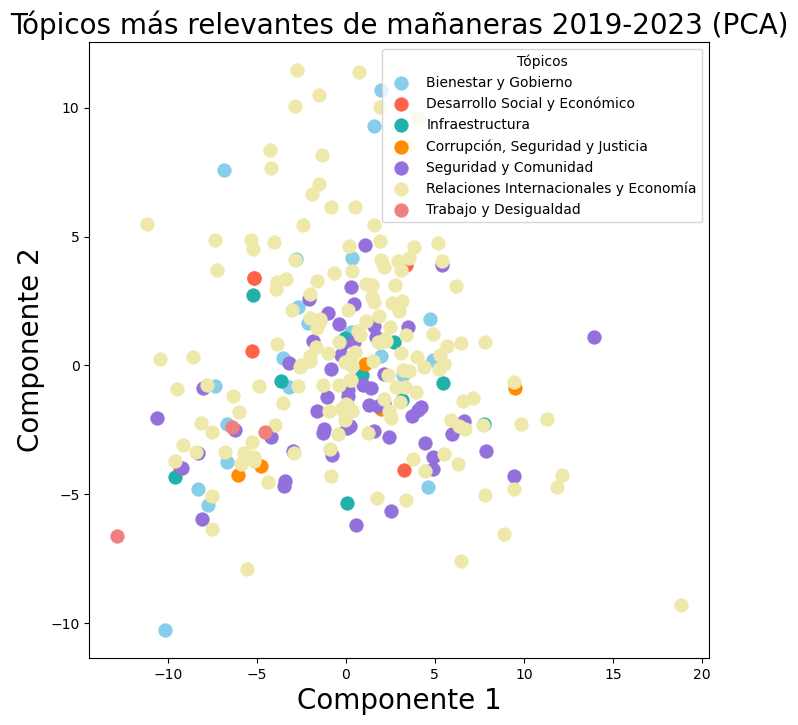

In [32]:
# Visualización con PCA
plot_projections(projections_PCA,w2v_categories_prom.reshape((261,)),target_names,'PCA','w2v')


In [33]:
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=2, kernel='linear')
X_transformed = transformer.fit_transform(w2v_embeddings_prom)
X_transformed.shape

(261, 2)

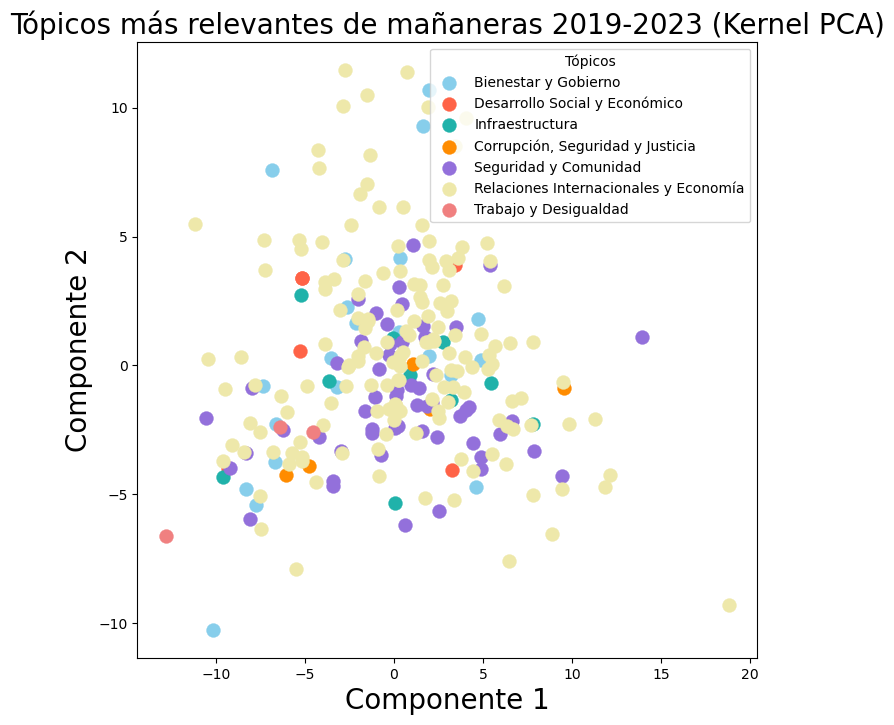

In [34]:
# Visualización con Kernel- PCA
plot_projections(X_transformed,w2v_categories_prom.reshape((261,)),target_names,'Kernel PCA', 'w2v')

In [35]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30).fit_transform(w2v_embeddings_prom)
X_embedded.shape

(261, 2)

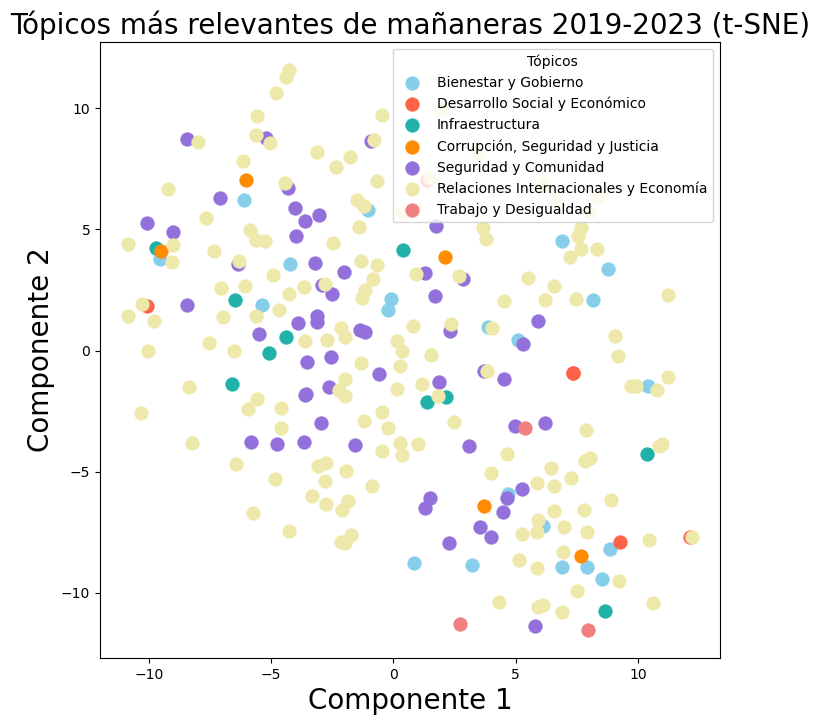

In [36]:
# Visualización t-SNE
plot_projections(X_embedded,w2v_categories_prom.reshape((261,)),target_names,'t-SNE','w2v')

## c) Indicador semanal para word2vec

In [37]:
topicos_codigo = ["ByGob", "DSEcon", "InfraPoder", "CorrSegJust", "SegCom", "RIEcon", "TrabDesig"]

In [75]:
# Vamos a construir una serie de tiempo que tenga el indicador por semana de cada tópico.
# Función all_emb_prom
def week_indicator(doc_series,vocab,topic_codes,norm):
    """ Descripción: Función calcular la matriz serie de tiempo con el indicador semanal
    Esta función toma los diccionarios de palabras y sus frecuencias. Vamos a dividir estos diccionarios
    en subdiccionarios que nos den la suma de las frecuencias de palabras en relación a su clúster
    Si hay 5 clústers, vamos a tomar el sub-diccionario que pertenece a cada clúster y vamos
    a sumar esas frecuencias. Una vez tengamos una tabla de frecuencias la vamos a normalizar por
    renglones para que tengamos un indicador por semana.
    
    Entradas: doc_series: Es la serie temporal de documentos
              vocab: Es un dataframe que contiene las columnas 'word' y 'topic' No nos interesa la columa
              'freq' porque esta tiene la frecuencia en toda la serie temporal, no por semana.
              topic_code: es una lista de códigos para cada tópico. (el orden importa)
              norm: Si norm es True, entonces calculamos la norma de cada renglón.
              
              
    Salida: Dataframe con las frecuencias de cada tópico por semana"""
    # Ciclo para obtener las frecuencias por semana de cada tópico
    all_freqs_by_week = []
    # arreglo dummy de ceros

    for doc in doc_series:
        freqs_by_week = []
        for topic in range(len(topic_codes)):
            # Se obtienen el subconjunto de palabras asociadas a un cierto tópico
            vocab_topic = vocab[vocab['topic']==topic]

            # Se obtienen los diccionarios de palabra:frecuencia
            word_freq_dic = obtain_words(doc,vocab_topic['word'].to_list())

            # ¿Puede haber diccionarios vacíos?
            if ( len(word_freq_dic) > 0 ):
                # Obtenemos las frecuencias de cada tópico para cada semana
                freq_of_topic = np.sum(np.array([word_freq_dic[key] for key in word_freq_dic.keys()]))
            else:
                # Si el diccionario está vacío, la frecuencia es cero.
                freq_of_topic = 0
            
            # Agregamos la frecuencia a una lista de frecuencias por semana
            freqs_by_week.append(freq_of_topic)
        
        # Agregamos las frecuencias de los tópicos por semana al arreglo de todas las semanas
        all_freqs_by_week.append(freqs_by_week) 

    # Si es True, se regresan las frecuencias normalizadas (Ya el indicador)
    if (norm == True):
        normalized = np.array(all_freqs_by_week)
        normalized = normalized / normalized.sum(axis=1, keepdims=True)
        freqs_week  = pd.DataFrame(normalized,columns=topic_codes)
    else:
        # Convertimos all_freqs_by_week a un dataframe
        freqs_week  = pd.DataFrame(all_freqs_by_week,columns=topic_codes)

    # Agregamos la columna de fecha con el index de doc_series
    freqs_week['Fecha'] = pd.to_datetime(doc_series.index)

    # La salida es el dataframe con el indicador semanal o las frecuencias por semana de cada tópico
    return freqs_week



In [76]:
# Función plot_series
def plot_series(Serie,year,path,model):
    """ Descripción: Función para automatizar la impresión de series de tiempo con varias categorías
    Entradas, Serie: la serie de interés en el intervalo deseado
              year: año que aparecerá en el título de la gráfica."""
    fig = px.line(Serie, x="Fecha", y=Serie.columns,
              hover_data={"Fecha": "|%B %d, %Y"},width=800,height=400)
    
    fig.update_xaxes(
        dtick="M1",
        tickformat="%b\n%Y")

    fig.update_layout(
        title='Relevancia de tópicos en las Mañaneras del Presidente AMLO '+year+ '('+model+')',
        xaxis_title="Fecha (semana)",
        yaxis_title="Relevancia",
        legend_title="Tópico",
        font=dict(size=15)
    )
    filename = f"{path}Tarea4_CDD/Topicos_{model}_{year}.png"
    fig.write_image(filename)
    print(f"Time Series during {year} using {model} saved as {filename}")
    fig.show()

In [77]:
# Calculamos el dataframe del indicador por semana de las mananeras
w2v_week_indicator = week_indicator(mananeras_filtradas,w2v_vocab,topicos_codigo,True)

w2v_week_indicator.head(10)

/tmp/ipykernel_176818/1281691151.py:49: RuntimeWarning:

invalid value encountered in divide



,ByGob,DSEcon,InfraPoder,CorrSegJust,SegCom,RIEcon,TrabDesig,Fecha
0,0.154305,0.135550,0.184996,0.035806,0.150043,0.154305,0.184996,2019-01-06
1,0.161985,0.147004,0.164794,0.029026,0.153090,0.204588,0.139513,2019-01-13
2,0.141554,0.166138,0.191911,0.026566,0.127676,0.205393,0.140761,2019-01-20
3,0.129209,0.154268,0.167189,0.034456,0.166797,0.182067,0.166014,2019-01-27
4,0.142962,0.147384,0.157332,0.046794,0.147752,0.196758,0.161017,2019-02-03
5,0.146691,0.136029,0.198897,0.026103,0.148162,0.160294,0.183824,2019-02-10
6,0.128989,0.136303,0.197473,0.027926,0.164894,0.166223,0.178191,2019-02-17
7,0.148604,0.143949,0.201130,0.025598,0.143617,0.167886,0.169215,2019-02-24
8,0.128226,0.139113,0.183065,0.045161,0.145565,0.189516,0.169355,2019-03-03
9,0.120407,0.140192,0.189938,0.025438,0.165065,0.188807,0.170153,2019-03-10


In [78]:
# Los temas en la semana 108 y 109 son nulos NO ESTÁN EN LA BASE DE DATOS
# Por esta razón se marcan como nan en la parte de arriba
# SE SUSTITUYEN POR CEROS
len_topics = len(topicos_codigo)
print(w2v_week_indicator[108:110])
w2v_week_indicator.iloc[108,:len_topics] = np.zeros(len_topics)
w2v_week_indicator.iloc[109,:len_topics] = np.zeros(len_topics)


     ByGob  DSEcon  InfraPoder  CorrSegJust  SegCom  RIEcon  TrabDesig  \
108    NaN     NaN         NaN          NaN     NaN     NaN        NaN   
109    NaN     NaN         NaN          NaN     NaN     NaN        NaN   

         Fecha  
108 2021-01-31  
109 2021-02-07  


In [79]:
# Función para automatizar la impresión de series de tiempo en diferentes intervalos
def plot_multiple_series(indicator,path,model):
    date_intervals = [['2019-01-01','2019-12-31'],
                      ['2020-01-01','2020-12-31'],
                      ['2021-01-01','2021-12-31'],
                      ['2022-01-01','2022-12-31'],
                      ['2023-01-01','2023-12-31']]
    years = ['2019','2020','2021','2022','2023']
    for interval in date_intervals:
        serie = indicator[(indicator['Fecha'] <= interval[1]) & (indicator['Fecha'] >= interval[0])]
        plot_series(serie,interval[0][:4],path,model)
        

In [80]:
# Impresión de series de tiempo para los años 2019-2023 usando w2v.
plot_multiple_series(w2v_week_indicator,PATH,'word2vec')

Time Series during 2019 using word2vec saved as /home/chay/CDD/Tarea4_CDD/Topicos_word2vec_2019.png


Time Series during 2020 using word2vec saved as /home/chay/CDD/Tarea4_CDD/Topicos_word2vec_2020.png


Time Series during 2021 using word2vec saved as /home/chay/CDD/Tarea4_CDD/Topicos_word2vec_2021.png


Time Series during 2022 using word2vec saved as /home/chay/CDD/Tarea4_CDD/Topicos_word2vec_2022.png


Time Series during 2023 using word2vec saved as /home/chay/CDD/Tarea4_CDD/Topicos_word2vec_2023.png


In [81]:
# Por ultimo la serie completa
plot_series(w2v_week_indicator,'(2019-2023)',PATH,'w2v')

Time Series during (2019-2023) using w2v saved as /home/chay/CDD/Tarea4_CDD/Topicos_w2v_(2019-2023).png


# 7) Determinamos las representaciones con Fasttext

In [363]:
from gensim.models import FastText

## a) Fasttext embeddings

In [368]:
# Cargamos los embeddings pre entrenados con word2vec
FastText = KeyedVectors.load_word2vec_format(PATH+'embeddings-l-model.vec')

In [370]:
# Calculamos los embeddings
embeddings_FastText = []
not_found_FT = []
for word in vocab['word']:
    try:
        embbeding = FastText[word]
        embeddings_FastText.append(embbeding)
    except KeyError:
        not_found_FT.append(word)

print('Forma del vocabulario: ',len(embeddings_FastText))
print('\n Vocabulario no encontrado:\n',not_found_FT)

Forma del vocabulario:  499

 Vocabulario no encontrado:
 ['covid']


In [371]:
# Removemos el vocabulario no encontrado en los embeddings
FT_vocab = vocab[~vocab['word'].isin(not_found_FT)].copy()
len(FT_vocab)

499

In [372]:
# Utilizamos los embeddings_FastText para hacer el Fuzzy K-means
embeddings_FastText = np.array(embeddings_FastText)
embeddings_FastText.shape

(499, 300)

## Fuzzy K-means: Utilizamos 7 clústers

In [403]:
# Utilizamos Fuzzy K-means con un grado de Fuzziness m=3
fcm_FT = FCM(n_clusters=4, m=3)
fcm_FT.fit(embeddings_FastText)

#y_fkm = np.matrix(fcm_FT.predict(embeddings_FastText)).T
topics_FT = [
    np.argmin(np.linalg.norm(fcm_FT.centers-embeddings_FastText[i],axis=1)) for i in range(len(FT_vocab))
]
FT_vocab['topic'] = topics_FT
FT_vocab

,word,freq,topic
0,méxico,82825,0
1,gobierno,68930,2
2,pueblo,68755,0
3,gente,64555,3
4,país,46615,0
...,...,...,...
495,exteriores,3005,1
496,inseguridad,3000,1
497,combustibles,2995,1
498,hugo,2990,0


In [404]:
FT_vocab['topic'].unique()

array([0, 2, 3, 1])

In [405]:
# Los centroides están dados por
fcm_FT.centers.shape

(4, 300)

In [406]:
# Iteramos sobre los topicos usando el vocabulario de FastText
for topic_label in range(4):
    # Llamada a la función de impresión de imagenes
    makeImage(FT_vocab[FT_vocab['topic'] == topic_label])

Figure for topic 0 saved as /home/chay/CDD/Tarea4_CDD/topic_0wc.png
Figure for topic 1 saved as /home/chay/CDD/Tarea4_CDD/topic_1wc.png
Figure for topic 2 saved as /home/chay/CDD/Tarea4_CDD/topic_2wc.png
Figure for topic 3 saved as /home/chay/CDD/Tarea4_CDD/topic_3wc.png


## b) Promedio de Embeddings por semana

In [407]:
# Determinamos los embeddings más relevantes por semana para word2vec
FT_embeddings_prom, FT_categories_prom = all_emb_prom(mananeras_filtradas,FT_vocab,FastText,300,fcm_FT)
print('Forma de FT_embeddings_prom: ',FT_embeddings_prom.shape)
print('Forma de FT_categories_prom: ',FT_categories_prom.shape)

Forma de FT_embeddings_prom:  (261, 300)
Forma de FT_categories_prom:  (261, 1)


In [439]:
target_names_FT  = ["Gobierno Nacional","Reformas y Programas Sociales","Política y Elecciones","Obras y Pueblo Mexicano"]
topicos_codigo_FT = ['GobNa','RefProgSoc','PolElec','ObrasPueb']

### Visualizaciones en baja dimensión
### PCA

In [440]:
# Observamos con PCA si hay algún patrón con PCA
from sklearn.decomposition import PCA
# Se estandarizan los datos
scaler = StandardScaler(with_mean=True,with_std=True)
FT_embeddings_prom = scaler.fit_transform(FT_embeddings_prom)

pca_FT_prom = PCA(n_components=2)
projections_PCA = pca_FT_prom.fit_transform(FT_embeddings_prom)
print(pca_FT_prom.explained_variance_ratio_)

[0.27537349 0.13043303]


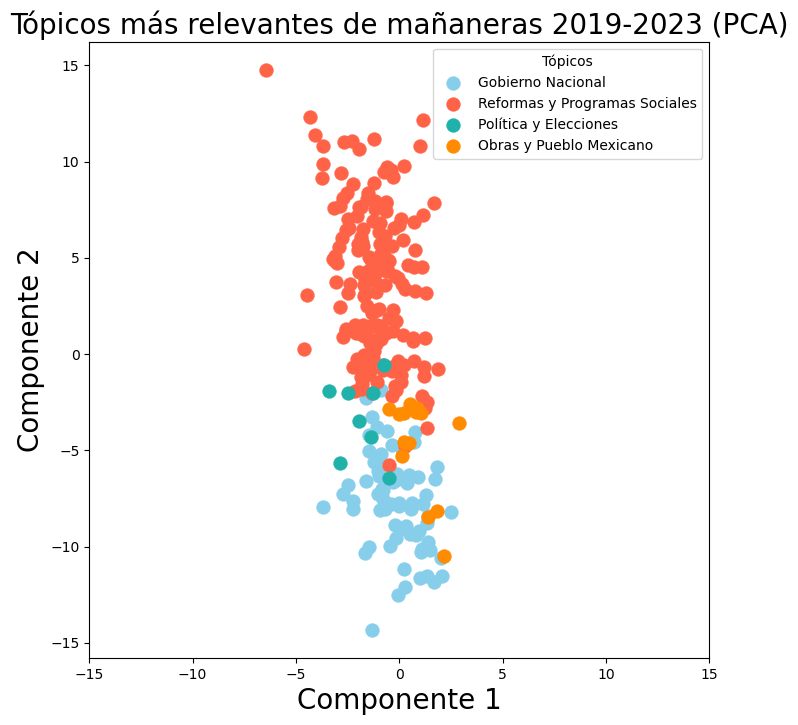

In [443]:
# Visualización con PCA
plot_projections(projections_PCA,FT_categories_prom.reshape((261,)),target_names_FT,'PCA','FT')


### Kernel PCA

In [444]:
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=2, kernel='linear')
X_transformed = transformer.fit_transform(FT_embeddings_prom)
X_transformed.shape

(261, 2)

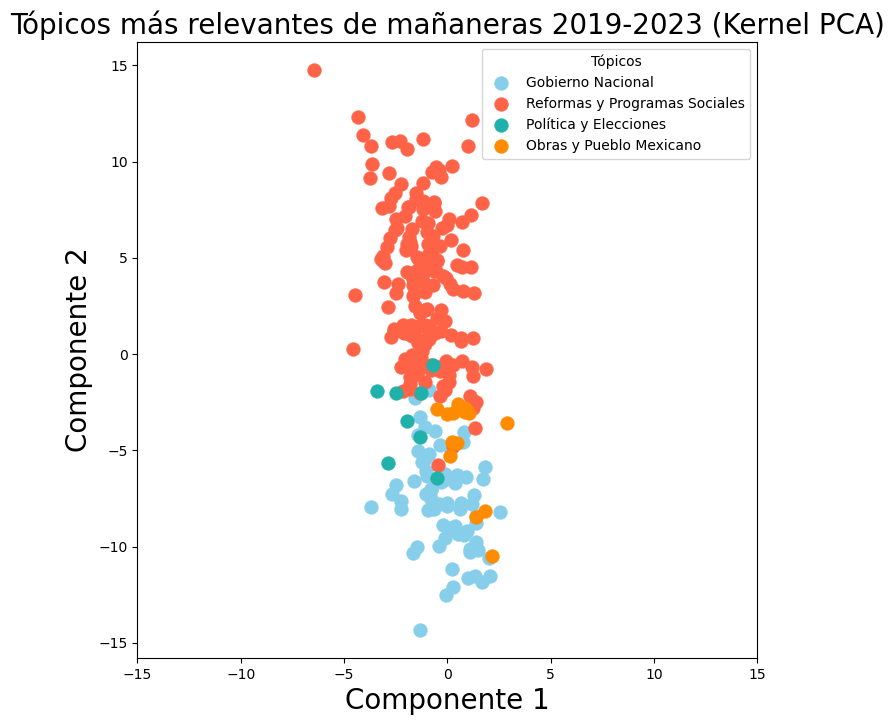

In [446]:
# Visualización con Kernel- PCA
plot_projections(X_transformed,FT_categories_prom.reshape((261,)),target_names_FT,'Kernel PCA', 'FT')

 ### t-SNE


In [447]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=15).fit_transform(FT_embeddings_prom)
X_embedded.shape

(261, 2)

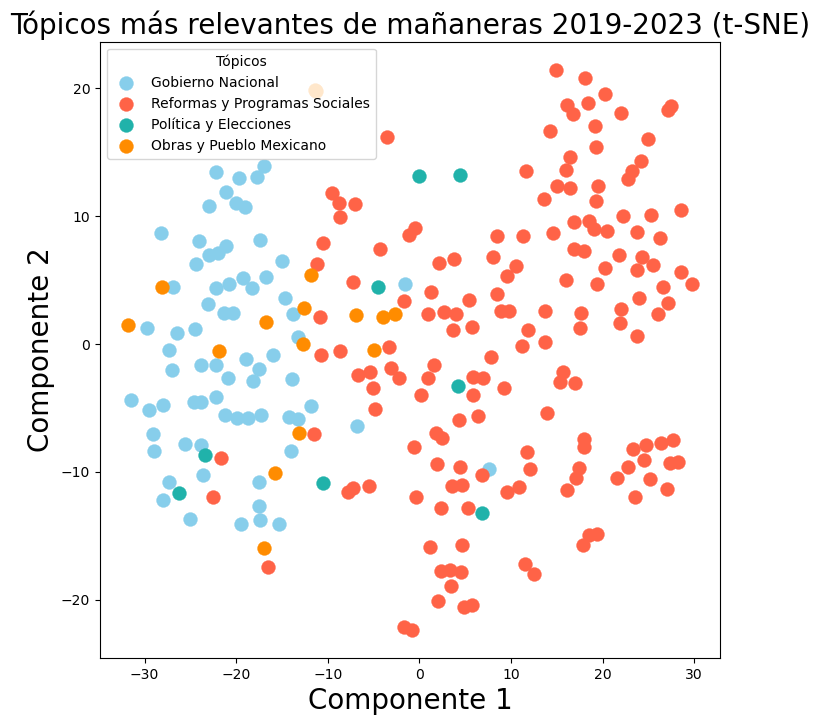

In [450]:
# Visualización t-SNE
plot_projections(X_embedded,FT_categories_prom.reshape((261,)),target_names_FT,'t-SNE','FT')

## c) Indicador semanal para FastText

In [451]:
# Calculamos el dataframe del indicador por semana de las mananeras
FT_week_indicator = week_indicator(mananeras_filtradas,FT_vocab,topicos_codigo_FT,True)
FT_week_indicator.head(10)

/tmp/ipykernel_12013/273640860.py:49: RuntimeWarning:

invalid value encountered in divide



,GobNa,RefProgSoc,PolElec,ObrasPueb,Fecha
0,0.152340,0.567660,0.065532,0.214468,2019-01-06
1,0.186981,0.552632,0.040628,0.219760,2019-01-13
2,0.186520,0.558386,0.046238,0.208856,2019-01-20
3,0.169702,0.601317,0.064316,0.164665,2019-01-27
4,0.197301,0.560540,0.066740,0.175419,2019-02-03
5,0.179645,0.587106,0.066280,0.166968,2019-02-10
6,0.172269,0.614092,0.061409,0.152230,2019-02-17
7,0.218894,0.552995,0.078999,0.149111,2019-02-24
8,0.209302,0.568565,0.058540,0.163593,2019-03-03
9,0.213326,0.534714,0.069989,0.181971,2019-03-10


In [452]:
# Los temas en la semana 108 y 109 son nulos NO ESTÁN EN LA BASE DE DATOS
# Por esta razón se marcan como nan en la parte de arriba
# SE SUSTITUYEN POR CEROS
len_topics_FT = len(topicos_codigo_FT)
print(FT_week_indicator[108:110])
FT_week_indicator.iloc[108,:len_topics_FT] = np.zeros(len_topics_FT)
FT_week_indicator.iloc[109,:len_topics_FT] = np.zeros(len_topics_FT)

     GobNa  RefProgSoc  PolElec  ObrasPueb      Fecha
108    NaN         NaN      NaN        NaN 2021-01-31
109    NaN         NaN      NaN        NaN 2021-02-07


In [454]:
# Impresión de series de tiempo para los años 2019-2023 usando w2v.
plot_multiple_series(FT_week_indicator,PATH,'FastText')

Time Series during 2019 using FastText saved as /home/chay/CDD/Tarea4_CDD/Topicos_FastText_2019.png


Time Series during 2020 using FastText saved as /home/chay/CDD/Tarea4_CDD/Topicos_FastText_2020.png


Time Series during 2021 using FastText saved as /home/chay/CDD/Tarea4_CDD/Topicos_FastText_2021.png


Time Series during 2022 using FastText saved as /home/chay/CDD/Tarea4_CDD/Topicos_FastText_2022.png


Time Series during 2023 using FastText saved as /home/chay/CDD/Tarea4_CDD/Topicos_FastText_2023.png


In [455]:
# Por ultimo la serie completa
plot_series(FT_week_indicator,'(2019-2023)',PATH,'FT')

Time Series during (2019-2023) using FT saved as /home/chay/CDD/Tarea4_CDD/Topicos_FT_(2019-2023).png
